In [1]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("NBA Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)
df = df[df['make_playoffs'] == 1]

print(list(df.columns))

['Season', 'Team', 'team_id', 'conference', 'max_player', 'champion_share', 'champion', 'Rk', 'rk_season', 'Arena', 'rk_conference', 'top_3_conference', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'offensive_eFG%', 'offensive_TOV%', 'offensive_ORB%', 'offensive_FT/FGA', 'defensive_eFG%', 'defensive_TOV%', 'defensive_DRB%', 'defensive_FT/FGA', 'Attend.', 'Attend./G', 'make_playoffs', 'overall_record', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'opp_G', 'opp_MP', 'opp_FG', 'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_2P', 'opp_2PA', 'opp_2P%', 'opp_FT', 'opp_FTA', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF', 'opp_PTS', 'pso', 'over500_rec', 'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_o

In [3]:
data_columns = ['rk_conference', 'top_3_conference', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
                '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'opp_G', 'opp_MP', 'opp_FG',
                'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_2P', 'opp_2PA', 'opp_2P%', 'opp_FT', 'opp_FTA', 'opp_FT%',
                'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF', 'opp_PTS', 'pso', 'over500_rec',
                'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_or_less_rec',
                '10pt_or_more_rec', 'pre_all_star_rec', 'post_all_star_rec', 'e_conf_rec', 'w_conf_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 
                'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_nba', 'sum_all_defense', 'sum_all_rookie',
                'sum_mvps_won', 'sum_dpoys_won', 'sum_roys_won', 'sum_mips_won', 'sum_cpoys_won', 'sum_all_nba_1st', 'sum_all_def_1st', 'sum_playoff_games',
                'sum_mvp_shares_L3S', 'sum_mvp_shares_L5S', 'sum_champion_shares', 'sum_champions', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs',
                'sum_player_L8S_cs', 'sum_all_nba_1st_L5S', 'team_rating_custom', 'max_player_rating_custom','sum_coach_playoff_games', 'sum_coy_shares',
                'conference_5pt_or_less_rec', 'conference_OR', 'conference_SRS', 'conference_age', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 
                'Pace', 'FTr', '3PAr', 'TS%', 'offensive_eFG%', 'offensive_TOV%', 'offensive_ORB%', 'offensive_FT/FGA', 'defensive_eFG%', 'defensive_TOV%',
                'defensive_DRB%', 'defensive_FT/FGA','overall_record', 'rk_season','sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs',
                 'rank_offensive_eFG%', 'rank_2P%', 'rank_sum_all_nba_1st_L5S', 'rank_SRS', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_SRS'
               ]

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [4]:
correlation_matrix = data.corr()

correlation_threshold = .75

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [5]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'rk_conference', 'G', 'MP', 'FG', 'FGA', '3P', '3P%', '2P%', 'FT', 'FT%', 'ORB', 'TRB', 'AST', 'PF', 'pso', 'over500_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_or_less_rec', '10pt_or_more_rec', 'pre_all_star_rec', 'post_all_star_rec', 'e_conf_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_defense', 'sum_all_rookie', 'sum_cpoys_won', 'sum_playoff_games', 'sum_mvp_shares_L3S', 'sum_champions', 'sum_player_L1S_cs', 'sum_all_nba_1st_L5S', 'max_player_rating_custom', 'sum_coach_playoff_games', 'conference_5pt_or_less_rec', 'conference_OR', 'conference_age', 'SOS', 'DRtg', 'sum_franchise_L3S_cs', 'rank_offensive_eFG%', 'rank_sum_all_nba_1st_L5S', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_SRS'

Columns that were removed:
'NRtg', 'sum_dpoys_won', 'ORtg', '2P', 'sum_all_nba_1st', 'Pace', 'opp_FG', '

In [6]:
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF',  'opp_3P%','opp_FT%', 'opp_ORB',
            'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%' , 'sum_franchise_L3S_cs', 'sum_playoff_games', 'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec',
            'offensive_eFG%', 'conference_OR', 'defensive_eFG%', 'sum_dpoys_won'
           ]

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 35


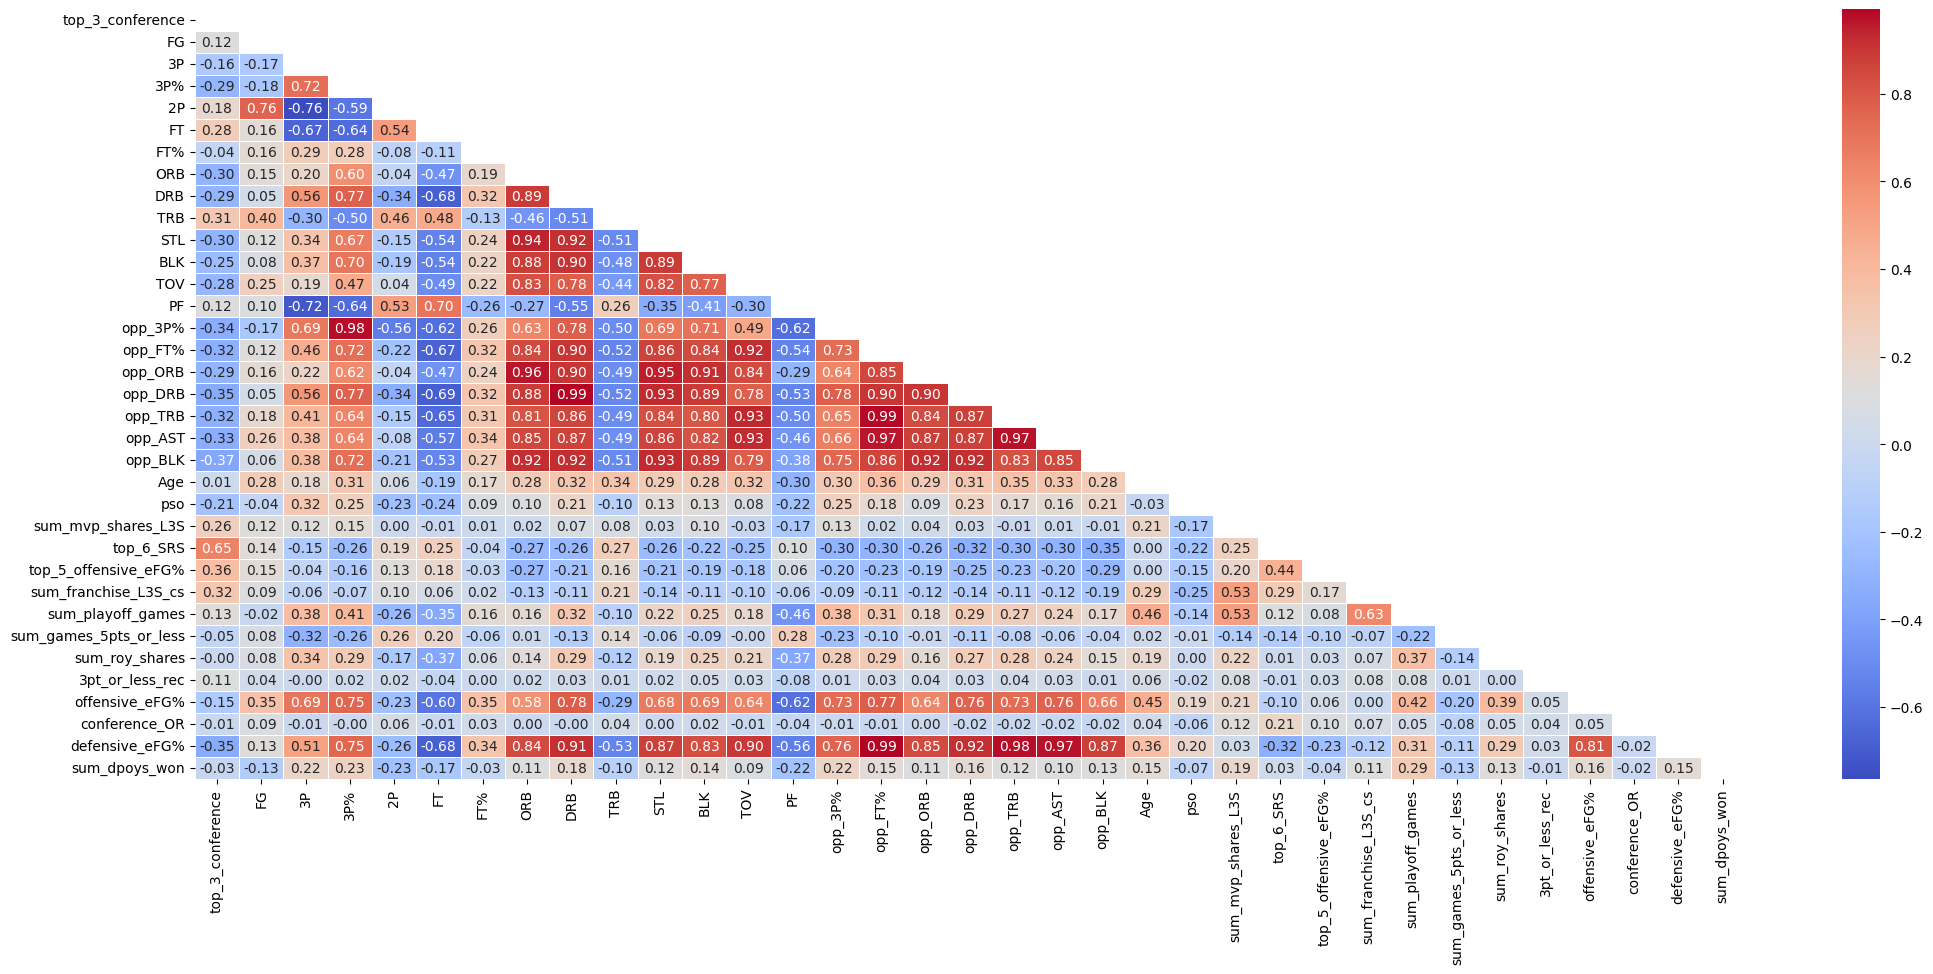

In [7]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Pr

Best Parameters from GridSearchCV:
{'alpha': 0.005, 'eta0': 0.01, 'l1_ratio': 0.1, 'learning_rate': 'adaptive'}
Test Set Mean Squared Error (MSE): 0.0338
Top Predictions:
    Season                    Team  champion_share  predicted_cs
0     2024          Boston Celtics          1.0000      0.631865
1     2024          Denver Nuggets          0.4375      0.567447
7     2024         Milwaukee Bucks          0.1250      0.524565
3     2024  Minnesota Timberwolves          0.5625      0.504266
2     2024   Oklahoma City Thunder          0.3750      0.491222
5     2024         New York Knicks          0.4375      0.457056
13    2024      Philadelphia 76ers          0.1250      0.155318
16    2024   Golden State Warriors          0.0000      0.150081
11    2024      Los Angeles Lakers          0.0625      0.126151
8     2024            Phoenix Suns          0.0000      0.119427
9     2024    New Orleans Pelicans          0.0000      0.118965
4     2024    Los Angeles Clippers          0.125

/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


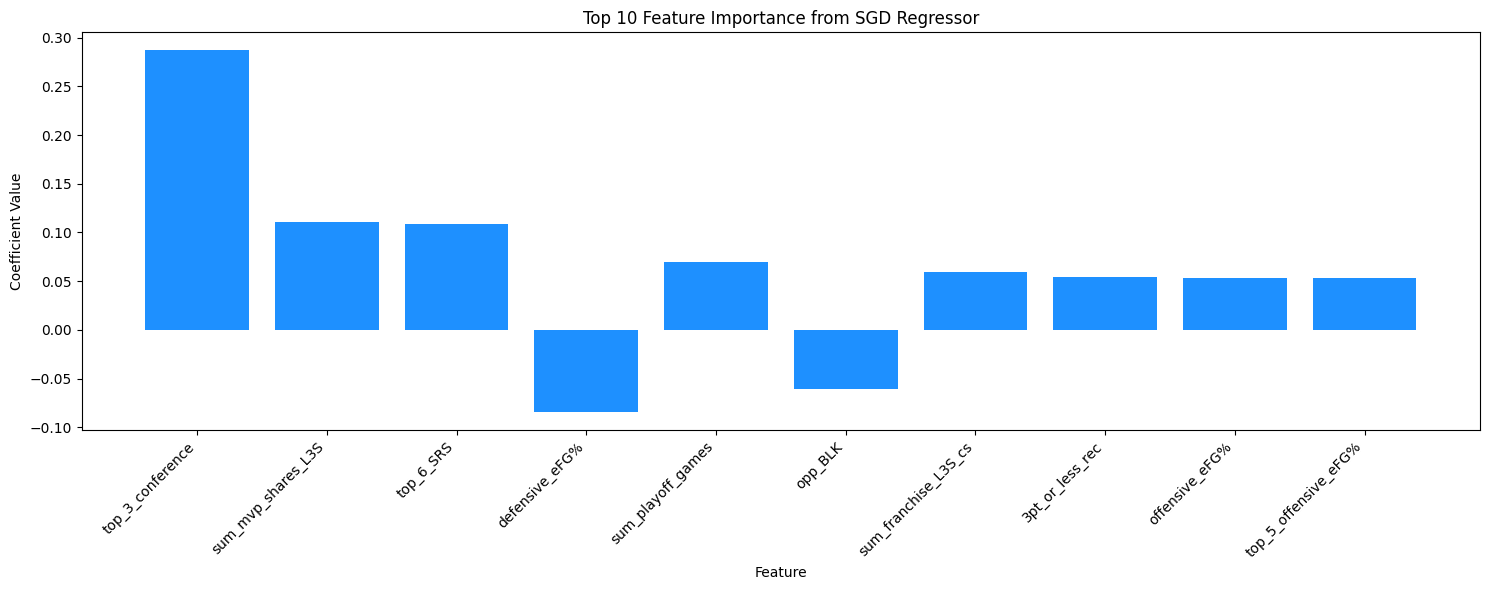

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Keep only playoff teams
# df = df[df['make_playoffs'] == 1]

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

# # Handle missing values with a median imputer
# imputer = SimpleImputer(strategy="median")
# df[features] = imputer.fit_transform(df[features])

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Scale features
scaler = MinMaxScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Define SGDRegressor with Elastic Net
sgd = SGDRegressor(penalty="elasticnet", loss="squared_error", random_state=42)

# GridSearchCV for hyperparameter tuning
param_grid = {
    "alpha": [0.001, 0.005, 0.01, 0.05],  # Regularization strength
    "l1_ratio": [0.1, 0.25, 0.5, 0.9],    # Elastic Net mix (L1/L2 balance)
    "learning_rate": ["constant", "optimal", "adaptive"],  # Learning rate type
    "eta0": [0.01, 0.05, 0.1, 0.3],       # Initial learning rate for 'constant' or 'adaptive'
}
grid_search = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",  # Minimize MSE
    n_jobs=-1,
    verbose=0
)

# Train model with GridSearchCV
grid_search.fit(train[features], train["champion_share"])

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:")
print(best_params)

# Test the best model on the test set
best_model_sgd = grid_search.best_estimator_
predictions = best_model_sgd.predict(test[features])

# Evaluate performance
mse = mean_squared_error(test["champion_share"], predictions)
print(f"Test Set Mean Squared Error (MSE): {mse:.4f}")

# Create results DataFrame
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
results = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
results.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

# Display top 16 teams for 2020+ seasons
print("Top Predictions:")
print(results.head(16))

# Plot feature importance (coefficients)
coefficients = best_model_sgd.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

top_features = sorted_feature_coefficients[:10]
features_names = [x[0] for x in top_features]
coeff_values = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, coeff_values, color='dodgerblue')
plt.title('Top 10 Feature Importance from SGD Regressor')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
# Print top 5 predicted teams for all test seasons - for the Linear Regression model
def print_top_5_per_season(results_df):
    grouped = results_df.groupby("Season")
    print("\nTop 5 Predicted Teams by Season (Test Set):")
    print("="*80)
    for season, group in grouped:
        print(f"\nSeason: {season}")
        print(group.head(5)[["Team", "predicted_cs", "champion_share"]].to_string(index=False))
        print("-"*80)

# Call the function with results DataFrame
print_top_5_per_season(results)


Top 5 Predicted Teams by Season (Test Set):

Season: 2020
                Team  predicted_cs  champion_share
  Los Angeles Lakers      0.675028          1.0000
     Milwaukee Bucks      0.654235          0.3125
Los Angeles Clippers      0.555098          0.4375
     Toronto Raptors      0.522081          0.4375
      Boston Celtics      0.510654          0.6250
--------------------------------------------------------------------------------

Season: 2021
                Team  predicted_cs  champion_share
     Milwaukee Bucks      0.638900          1.0000
           Utah Jazz      0.594511          0.3750
Los Angeles Clippers      0.587677          0.6250
  Philadelphia 76ers      0.563477          0.4375
        Phoenix Suns      0.550130          0.8750
--------------------------------------------------------------------------------

Season: 2022
                 Team  predicted_cs  champion_share
Golden State Warriors      0.633678          1.0000
         Phoenix Suns      0.612257

### SHAP Plot for Linear SGD Regressor

Top 10 Features by SHAP Importance:
['top_3_conference', 'top_6_SRS', 'sum_mvp_shares_L3S', 'top_5_offensive_eFG%', 'defensive_eFG%', 'opp_BLK', 'sum_franchise_L3S_cs', 'conference_OR', 'sum_dpoys_won', 'sum_playoff_games']


/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


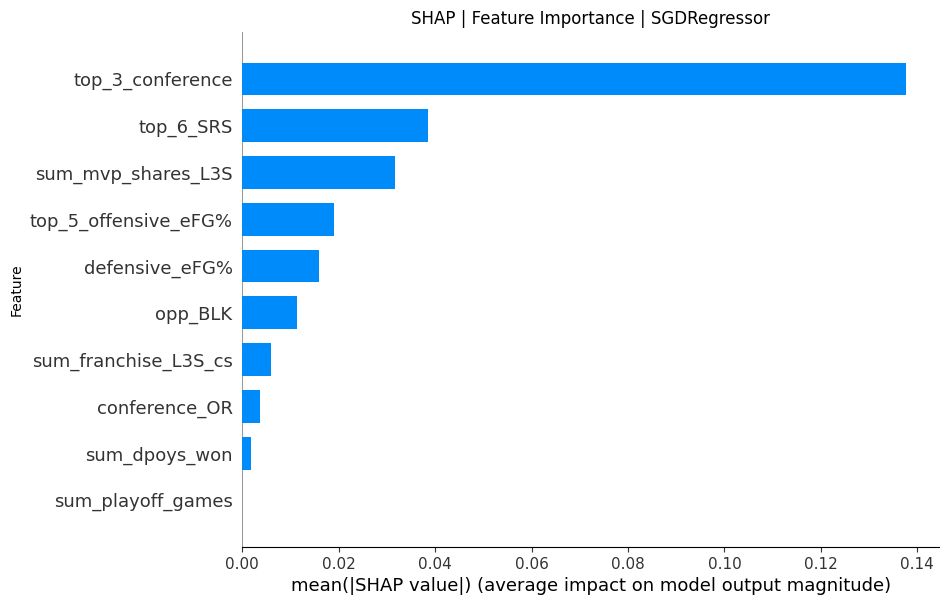

In [36]:
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

# Create SHAP explainer for the trained linear model
explainer = shap.LinearExplainer(best_model_sgd, train[features], feature_perturbation="interventional")
shap_values = explainer.shap_values(test[features])

# Compute mean absolute SHAP values for feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]  # Indices of top 10 features

# Get names of the top features
top_features_list = [features[index] for index in top_features]
print("Top 10 Features by SHAP Importance:")
print(top_features_list)

# Extract SHAP values and corresponding test data for top features
shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

# Plot SHAP summary bar chart for top 10 features
shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | SGDRegressor')

# Save and format the plot as an image
plt.savefig("sgd_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("sgd_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("sgd_shap_bar_with_border.png")

plt.ylabel("Feature")
plt.show()


### XG-Boost Regression:

Best Parameters from RandomizedSearchCV:
{'subsample': 0.9, 'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
Test Set Mean Squared Error (MSE): 0.0368

Top 5 Predicted Teams by Season (Test Set):

Season: 2020
                Team  predicted_cs  champion_share
  Los Angeles Lakers      0.688845          1.0000
Los Angeles Clippers      0.651928          0.4375
     Milwaukee Bucks      0.555224          0.3125
     Toronto Raptors      0.465671          0.4375
      Boston Celtics      0.454045          0.6250
--------------------------------------------------------------------------------

Season: 2021
                Team  predicted_cs  champion_share
     Milwaukee Bucks      0.555756          1.0000
Los Angeles Clippers      0.546014          0.6250
      Denver Nuggets      0.528568          0.2500
  Philadelphia 76ers      0.524318          0.4375
           Utah Jazz      0.508369          0.3750
-----------------------------------------------

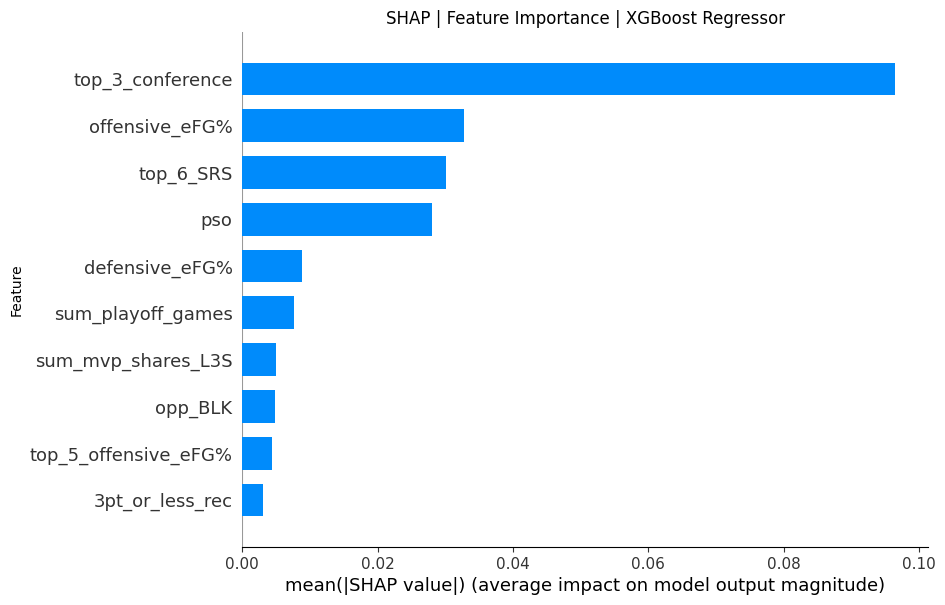

In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

# Define the XGBoost regressor
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# Random search parameter grid
param_grid = {
    "n_estimators": [150, 200, 250, 400, 500, 600, 800, 1000],       # Number of trees
    "max_depth": [1, 2, 3, 4, 5, 6, 10, 15, 20],         # Maximum depth of trees
    "learning_rate": [0.001, 0.005, 0.01, 0.03, 0.05, 0.1],                   # Step size shrinkage
    "subsample": [0.8, 0.9, 1.0],                   # Fraction of samples used for training each tree
    "colsample_bytree": [0.8, 0.9, 1.0]             # Fraction of features used for training each tree
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=100,  # Number of random combinations to evaluate
    cv=5,       # 5-fold cross-validation
    scoring="neg_mean_squared_error",  # Minimize MSE
    n_jobs=-1,
    verbose=0,
    random_state=42
)

# Train model with RandomizedSearchCV
random_search.fit(train[features], train["champion_share"])

# Best hyperparameters
best_params = random_search.best_params_
print("Best Parameters from RandomizedSearchCV:")
print(best_params)

# Test the best model on the test set
best_model_xgb = random_search.best_estimator_
predictions = best_model_xgb.predict(test[features])

# Evaluate performance
mse = mean_squared_error(test["champion_share"], predictions)
print(f"Test Set Mean Squared Error (MSE): {mse:.4f}")

# Create results DataFrame
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
results = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
results.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

# Display top 5 predicted teams for all test seasons
def print_top_5_per_season(results_df):
    grouped = results_df.groupby("Season")
    print("\nTop 5 Predicted Teams by Season (Test Set):")
    print("="*80)
    for season, group in grouped:
        print(f"\nSeason: {season}")
        print(group.head(5)[["Team", "predicted_cs", "champion_share"]].to_string(index=False))
        print("-"*80)

print_top_5_per_season(results)

# SHAP Feature Importance Visualization
explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(test[features])

# Compute mean absolute SHAP values for feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]  # Indices of top 10 features

# Get names of the top features
top_features_list = [features[index] for index in top_features]
print("Top 10 Features by SHAP Importance:")
print(top_features_list)

# Extract SHAP values and corresponding test data for top features
shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

# Plot SHAP summary bar chart for top 10 features
shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | XGBoost Regressor')

# Save and format the plot as an image
plt.savefig("xgboost_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("xgboost_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("xgboost_shap_bar_with_border.png")

plt.ylabel("Feature")
plt.show()


Top 5 Teams Comparison for Test Set:

Season: 2020
                Team  Actual_CS  SGD_Predicted_CS  XGBoost_Predicted_CS  Average_Predicted_CS
  Los Angeles Lakers     1.0000          0.668654              0.651950              0.655291
Los Angeles Clippers     0.4375          0.560346              0.613504              0.602872
     Milwaukee Bucks     0.3125          0.656210              0.545955              0.568006
     Toronto Raptors     0.4375          0.525503              0.453342              0.467774
      Boston Celtics     0.6250          0.512522              0.445160              0.458632
--------------------------------------------------------------------------------

Season: 2021
                Team  Actual_CS  SGD_Predicted_CS  XGBoost_Predicted_CS  Average_Predicted_CS
     Milwaukee Bucks     1.0000          0.658982              0.566041              0.584629
       Brooklyn Nets     0.4375          0.583449              0.557890              0.563002
Los Ange

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2182599505.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, "Average_Predicted_CS"))  # Get top 5 based on average predicted CS


### Ensembling the Linear SGD model and the XG-Boost model for higher robustness

In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']

# Scale features
scaler = StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Train SGDRegressor with GridSearchCV
sgd = SGDRegressor(
    penalty="elasticnet",
    loss="squared_error",
    random_state=42
)
param_grid_sgd = {
    "alpha": [0.001, 0.005, 0.01, 0.05],
    "l1_ratio": [0.1, 0.25, 0.5, 0.9],
    "learning_rate": ["constant", "optimal", "adaptive"],
    "eta0": [0.01, 0.05, 0.1, 0.3],
}
grid_search_sgd = GridSearchCV(sgd, param_grid=param_grid_sgd, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_sgd.fit(train[features], train["champion_share"])
best_model_sgd = grid_search_sgd.best_estimator_

# Train XGBoost with RandomizedSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
param_grid_xgb = {
    "n_estimators": [150, 200, 250, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_grid_xgb, n_iter=50, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
random_search_xgb.fit(train[features], train["champion_share"])
best_model_xgb = random_search_xgb.best_estimator_

# Tune ensemble weights using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_weights = None
best_cv_mse = float('inf')

for sgd_weight in np.linspace(0, 1, 11):
    xgb_weight = 1 - sgd_weight
    cv_mse = 0
    
    for train_index, val_index in kf.split(train):
        X_train, X_val = train.iloc[train_index][features], train.iloc[val_index][features]
        y_train, y_val = train.iloc[train_index]["champion_share"], train.iloc[val_index]["champion_share"]

        sgd_preds = best_model_sgd.predict(X_val)
        xgb_preds = best_model_xgb.predict(X_val)
        ensemble_preds = sgd_weight * sgd_preds + xgb_weight * xgb_preds
        cv_mse += mean_squared_error(y_val, ensemble_preds)
    
    cv_mse /= kf.get_n_splits()
    
    if cv_mse < best_cv_mse:
        best_cv_mse = cv_mse
        best_weights = (sgd_weight, xgb_weight)

print(f"Best Ensemble Weights: SGD={best_weights[0]}, XGB={best_weights[1]} with CV MSE={best_cv_mse:.4f}")

# Combine predictions on test set using best weights
sgd_preds = best_model_sgd.predict(test[features])
xgb_preds = best_model_xgb.predict(test[features])
ensemble_preds = best_weights[0] * sgd_preds + best_weights[1] * xgb_preds

# Regression MSE
mse = mean_squared_error(test["champion_share"], ensemble_preds)
print(f"Ensemble Test Set Mean Squared Error (MSE): {mse:.4f}")

# Champion prediction using argmax of champion_share
test["predicted_cs"] = ensemble_preds
champion_predictions = test.groupby("Season", group_keys=False).apply(
    lambda df: df.nlargest(3, "predicted_cs")
)

actual_champions = test.groupby("Season", group_keys=False).apply(
    lambda df: df.loc[df["champion_share"].idxmax()]
)

# Print top 3 predicted teams for each season
print("\nTop 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)

# Accuracy for predicting champions
champion_accuracy = (champion_predictions.groupby("Season").first()["Team"].values == actual_champions["Team"].values).mean()
print(f"Champion Prediction Accuracy: {champion_accuracy:.4f}")

# Results summary
print("\nChampion Predictions:")
print(champion_predictions.groupby("Season").first()[["Team", "predicted_cs"]])
print("\nActual Champions:")
print(actual_champions[["Team", "champion_share"]])


/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

Best Ensemble Weights: SGD=0.0, XGB=1.0 with CV MSE=0.0181
Ensemble Test Set Mean Squared Error (MSE): 0.0376

Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.677661
Los Angeles Clippers      0.612411
     Milwaukee Bucks      0.571922
----------------------------------------
Season 2021:
              Team  predicted_cs
Philadelphia 76ers      0.574823
     Brooklyn Nets      0.557580
   Milwaukee Bucks      0.545344
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.586908
         Phoenix Suns      0.584406
      Milwaukee Bucks      0.539349
----------------------------------------
Season 2023:
           Team  predicted_cs
Milwaukee Bucks      0.544635
 Denver Nuggets      0.543586
 Boston Celtics      0.532150
----------------------------------------
Season 2024:
           Team  predicted_cs
 Boston Celtics      0.636492
 Denver Nuggets      0.598791


/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2122663987.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2122663987.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season", group_keys=False).apply(


In [49]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']

# Scale features
scaler = MinMaxScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Define extended parameter grids
param_grid_sgd = {
    "alpha": [0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
    "l1_ratio": [0.05, 0.1, 0.15, 0.2],
    "learning_rate": ["adaptive"],
    "eta0": [0.005, 0.01, 0.02, 0.03],
}

param_grid_xgb = {
    "n_estimators": [150, 180, 200, 220, 250],
    "max_depth": [1, 2, 3, 4],
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "subsample": [0.8, 0.85, 0.9, 0.95],
    "colsample_bytree": [0.8, 0.85, 0.9, 0.95],
}

# Train SGDRegressor with extended GridSearchCV
sgd = SGDRegressor(penalty="elasticnet", loss="squared_error", random_state=42, max_iter=5000)
grid_search_sgd = GridSearchCV(sgd, param_grid=param_grid_sgd, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_sgd.fit(train[features], train["champion_share"])
best_model_sgd = grid_search_sgd.best_estimator_
print("Extended SGD Best Parameters:")
print(grid_search_sgd.best_params_)

# Train XGBoost with extended GridSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search_xgb = GridSearchCV(
    xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
grid_search_xgb.fit(train[features], train["champion_share"])
best_model_xgb = grid_search_xgb.best_estimator_
print("Extended XGBoost Best Parameters:")
print(grid_search_xgb.best_params_)

# Tune ensemble weights using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_weights = None
best_cv_mse = float('inf')

for sgd_weight in np.linspace(0, 1, 21):  # Fine-grained search in 0.05 increments
    xgb_weight = 1 - sgd_weight
    cv_mse = 0
    
    for train_index, val_index in kf.split(train):
        X_train, X_val = train.iloc[train_index][features], train.iloc[val_index][features]
        y_train, y_val = train.iloc[train_index]["champion_share"], train.iloc[val_index]["champion_share"]

        sgd_preds = best_model_sgd.predict(X_val)
        xgb_preds = best_model_xgb.predict(X_val)
        ensemble_preds = sgd_weight * sgd_preds + xgb_weight * xgb_preds
        cv_mse += mean_squared_error(y_val, ensemble_preds)
    
    cv_mse /= kf.get_n_splits()
    
    if cv_mse < best_cv_mse:
        best_cv_mse = cv_mse
        best_weights = (sgd_weight, xgb_weight)

print(f"Best Ensemble Weights: SGD={best_weights[0]:.2f}, XGB={best_weights[1]:.2f} with CV MSE={best_cv_mse:.4f}")

# Combine predictions on test set using best weights
sgd_preds = best_model_sgd.predict(test[features])
xgb_preds = best_model_xgb.predict(test[features])
ensemble_preds = best_weights[0] * sgd_preds + best_weights[1] * xgb_preds

# Regression MSE
mse = mean_squared_error(test["champion_share"], ensemble_preds)
print(f"Ensemble Test Set Mean Squared Error (MSE): {mse:.4f}")

# Champion prediction using argmax of champion_share
test["predicted_cs"] = ensemble_preds
champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])

# Print top 3 predicted teams for each season
print("\nTop 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)

# Accuracy for predicting champions
champion_accuracy = (champion_predictions.groupby("Season").first()["Team"].values == actual_champions["Team"].values).mean()
print(f"Champion Prediction Accuracy: {champion_accuracy:.4f}")

# Results summary
print("\nChampion Predictions:")
print(champion_predictions.groupby("Season").first()[["Team", "predicted_cs"]])
print("\nActual Champions:")
print(actual_champions[["Team", "champion_share"]])


Extended SGD Best Parameters:
{'alpha': 0.002, 'eta0': 0.005, 'l1_ratio': 0.05, 'learning_rate': 'adaptive'}


/Users/matthewlee/Desktop/Stanford MSME/Y1Q1/CS 229/NBA Prediction/CS 229 Final Project/NBA-Champion-Prediction/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Extended XGBoost Best Parameters:
{'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 1, 'n_estimators': 220, 'subsample': 0.85}
Best Ensemble Weights: SGD=0.35, XGB=0.65 with CV MSE=0.0243
Ensemble Test Set Mean Squared Error (MSE): 0.0351

Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.674377
Los Angeles Clippers      0.611734
     Milwaukee Bucks      0.581118
----------------------------------------
Season 2021:
                Team  predicted_cs
     Milwaukee Bucks      0.575847
Los Angeles Clippers      0.557498
  Philadelphia 76ers      0.535543
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.573162
         Phoenix Suns      0.566453
           Miami Heat      0.513988
----------------------------------------
Season 2023:
           Team  predicted_cs
 Boston Celtics      0.571253
Milwaukee Bucks      0.570863
 Denver Nuggets      0.56

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/1356372427.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/1356372427.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season

In [50]:
# Set up data_columns
data_columns = ['rk_conference', 'top_3_conference', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
                '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'opp_G', 'opp_MP', 'opp_FG',
                'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_2P', 'opp_2PA', 'opp_2P%', 'opp_FT', 'opp_FTA', 'opp_FT%',
                'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF', 'opp_PTS', 'pso', 'over500_rec',
                'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_or_less_rec',
                '10pt_or_more_rec', 'pre_all_star_rec', 'post_all_star_rec', 'e_conf_rec', 'w_conf_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 
                'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_nba', 'sum_all_defense', 'sum_all_rookie',
                'sum_mvps_won', 'sum_dpoys_won', 'sum_roys_won', 'sum_mips_won', 'sum_cpoys_won', 'sum_all_nba_1st', 'sum_all_def_1st', 'sum_playoff_games',
                'sum_mvp_shares_L3S', 'sum_mvp_shares_L5S', 'sum_champion_shares', 'sum_champions', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs',
                'sum_player_L8S_cs', 'sum_all_nba_1st_L5S', 'team_rating_custom', 'max_player_rating_custom','sum_coach_playoff_games', 'sum_coy_shares',
                'conference_5pt_or_less_rec', 'conference_OR', 'conference_SRS', 'conference_age', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 
                'Pace', 'FTr', '3PAr', 'TS%', 'offensive_eFG%', 'offensive_TOV%', 'offensive_ORB%', 'offensive_FT/FGA', 'defensive_eFG%', 'defensive_TOV%',
                'defensive_DRB%', 'defensive_FT/FGA','overall_record', 'rk_season','sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs',
                 'rank_offensive_eFG%', 'rank_2P%', 'rank_sum_all_nba_1st_L5S', 'rank_SRS', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_SRS'
               ]

# Drop rows with missing data in relevant columns
df = df.dropna(subset=data_columns)
data = df[data_columns].copy()

# Compute correlation matrix
correlation_matrix = data.corr()

# Loosen correlation threshold
correlation_threshold = 0.85  # Adjusted threshold to keep more features

columns_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)

# Remove highly correlated columns
data_filtered = data.drop(columns=columns_to_remove)

print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

# Select final features
features = data_filtered.columns.tolist()
num_features = len(features)

print(f"\nNumber of features: {num_features}")


Columns in data_filtered:
'rk_conference', 'top_3_conference', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3P%', '2P', '2P%', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'opp_FG', 'opp_FG%', 'opp_3P%', 'opp_2P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_STL', 'opp_BLK', 'pso', 'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', '3pt_or_less_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_defense', 'sum_all_rookie', 'sum_mips_won', 'sum_playoff_games', 'sum_mvp_shares_L3S', 'sum_champions', 'sum_player_L1S_cs', 'sum_all_nba_1st_L5S', 'max_player_rating_custom', 'sum_coach_playoff_games', 'sum_coy_shares', 'conference_5pt_or_less_rec', 'conference_OR', 'conference_age', 'Age', 'SOS', 'ORtg', 'defensive_TOV%', 'sum_franchise_L3S_cs', 'sum_franchise_L8S_cs', 'rank_offensive_eFG%', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_S

In [70]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

data_columns = ['rk_conference', 'top_3_conference', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
                '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'opp_G', 'opp_MP', 'opp_FG',
                'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_2P', 'opp_2PA', 'opp_2P%', 'opp_FT', 'opp_FTA', 'opp_FT%',
                'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF', 'opp_PTS', 'pso', 'over500_rec',
                'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_or_less_rec',
                '10pt_or_more_rec', 'pre_all_star_rec', 'post_all_star_rec', 'e_conf_rec', 'w_conf_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 
                'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_nba', 'sum_all_defense', 'sum_all_rookie',
                'sum_mvps_won', 'sum_dpoys_won', 'sum_roys_won', 'sum_mips_won', 'sum_cpoys_won', 'sum_all_nba_1st', 'sum_all_def_1st', 'sum_playoff_games',
                'sum_mvp_shares_L3S', 'sum_mvp_shares_L5S', 'sum_champion_shares', 'sum_champions', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs',
                'sum_player_L8S_cs', 'sum_all_nba_1st_L5S', 'team_rating_custom', 'max_player_rating_custom','sum_coach_playoff_games', 'sum_coy_shares',
                'conference_5pt_or_less_rec', 'conference_OR', 'conference_SRS', 'conference_age', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 
                'Pace', 'FTr', '3PAr', 'TS%', 'offensive_eFG%', 'offensive_TOV%', 'offensive_ORB%', 'offensive_FT/FGA', 'defensive_eFG%', 'defensive_TOV%',
                'defensive_DRB%', 'defensive_FT/FGA','overall_record', 'rk_season','sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs',
                 'rank_offensive_eFG%', 'rank_2P%', 'rank_sum_all_nba_1st_L5S', 'rank_SRS', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_SRS'
               ]

# Drop rows with missing data
df = df.dropna(subset=data_columns)
data = df[data_columns].copy()

# Compute correlation matrix and remove highly correlated features
correlation_matrix = data.corr()
correlation_threshold = 0.80
columns_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            columns_to_remove.add(correlation_matrix.columns[j])
data_filtered = data.drop(columns=columns_to_remove)
features = data_filtered.columns.tolist()

# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Scale features
scaler = MinMaxScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Define extended parameter grids
param_grid_sgd = {
    "alpha": [0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
    "l1_ratio": [0.05, 0.1, 0.15, 0.2],
    "learning_rate": ["adaptive"],
    "eta0": [0.005, 0.01, 0.02, 0.03],
}

param_grid_xgb = {
    "n_estimators": [150, 180, 200, 220, 250],
    "max_depth": [1, 2, 3, 4],
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "subsample": [0.8, 0.85, 0.9, 0.95],
    "colsample_bytree": [0.8, 0.85, 0.9, 0.95],
}

# Train SGDRegressor with extended GridSearchCV
sgd = SGDRegressor(penalty="elasticnet", loss="squared_error", random_state=42, max_iter=5000)
grid_search_sgd = GridSearchCV(sgd, param_grid=param_grid_sgd, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_sgd.fit(train[features], train["champion_share"])
best_model_sgd = grid_search_sgd.best_estimator_
print("Extended SGD Best Parameters:")
print(grid_search_sgd.best_params_)

# SGD Results
sgd_preds = best_model_sgd.predict(test[features])
sgd_mse = mean_squared_error(test["champion_share"], sgd_preds)
print(f"SGD Test Set Mean Squared Error (MSE): {sgd_mse:.4f}")

# Top 3 Predictions and Accuracy for SGD
test["sgd_predicted_cs"] = sgd_preds
sgd_champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "sgd_predicted_cs"))
sgd_actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])
sgd_accuracy = (sgd_champion_predictions.groupby("Season").first()["Team"].values == sgd_actual_champions["Team"].values).mean()
print(f"SGD Champion Prediction Accuracy: {sgd_accuracy:.4f}")

# Print top 3 predictions for SGD
print("\nSGD Top 3 Predicted Teams per Season:")
for season, group in sgd_champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "sgd_predicted_cs"]].to_string(index=False))
    print("-" * 40)

# Train XGBoost with extended GridSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search_xgb = GridSearchCV(
    xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
grid_search_xgb.fit(train[features], train["champion_share"])
best_model_xgb = grid_search_xgb.best_estimator_
print("Extended XGBoost Best Parameters:")
print(grid_search_xgb.best_params_)

# XGBoost Results
xgb_preds = best_model_xgb.predict(test[features])
xgb_mse = mean_squared_error(test["champion_share"], xgb_preds)
print(f"XGBoost Test Set Mean Squared Error (MSE): {xgb_mse:.4f}")

# Top 3 Predictions and Accuracy for XGBoost
test["xgb_predicted_cs"] = xgb_preds
xgb_champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "xgb_predicted_cs"))
xgb_accuracy = (xgb_champion_predictions.groupby("Season").first()["Team"].values == sgd_actual_champions["Team"].values).mean()
print(f"XGBoost Champion Prediction Accuracy: {xgb_accuracy:.4f}")

# Print top 3 predictions for XGBoost
print("\nXGBoost Top 3 Predicted Teams per Season:")
for season, group in xgb_champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "xgb_predicted_cs"]].to_string(index=False))
    print("-" * 40)

# Ensemble and Evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_weights = None
best_cv_mse = float('inf')

for sgd_weight in np.linspace(0, 1, 21):  # Fine-grained search in 0.05 increments
    xgb_weight = 1 - sgd_weight
    cv_mse = 0
    
    for train_index, val_index in kf.split(train):
        X_train, X_val = train.iloc[train_index][features], train.iloc[val_index][features]
        y_train, y_val = train.iloc[train_index]["champion_share"], train.iloc[val_index]["champion_share"]

        sgd_preds_val = best_model_sgd.predict(X_val)
        xgb_preds_val = best_model_xgb.predict(X_val)
        ensemble_preds_val = sgd_weight * sgd_preds_val + xgb_weight * xgb_preds_val
        cv_mse += mean_squared_error(y_val, ensemble_preds_val)
    
    cv_mse /= kf.get_n_splits()
    
    if cv_mse < best_cv_mse:
        best_cv_mse = cv_mse
        best_weights = (sgd_weight, xgb_weight)

print(f"Best Ensemble Weights: SGD={best_weights[0]:.2f}, XGB={best_weights[1]:.2f} with CV MSE={best_cv_mse:.4f}")

# Combine predictions on test set using best weights
ensemble_preds = best_weights[0] * sgd_preds + best_weights[1] * xgb_preds

# Ensemble Results
ensemble_mse = mean_squared_error(test["champion_share"], ensemble_preds)
print(f"Ensemble Test Set Mean Squared Error (MSE): {ensemble_mse:.4f}")

# Champion prediction for ensemble
test["predicted_cs"] = ensemble_preds
champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])
ensemble_accuracy = (champion_predictions.groupby("Season").first()["Team"].values == actual_champions["Team"].values).mean()
print(f"Ensemble Champion Prediction Accuracy: {ensemble_accuracy:.4f}")

# Print top 3 predictions for Ensemble
print("\nEnsemble Top 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)



Extended SGD Best Parameters:
{'alpha': 0.007, 'eta0': 0.03, 'l1_ratio': 0.05, 'learning_rate': 'adaptive'}
SGD Test Set Mean Squared Error (MSE): 0.0333
SGD Champion Prediction Accuracy: 0.6000

SGD Top 3 Predicted Teams per Season:
Season 2020:
                Team  sgd_predicted_cs
  Los Angeles Lakers          0.679656
     Milwaukee Bucks          0.653436
Los Angeles Clippers          0.562254
----------------------------------------
Season 2021:
                Team  sgd_predicted_cs
     Milwaukee Bucks          0.639042
           Utah Jazz          0.597580
Los Angeles Clippers          0.592655
----------------------------------------
Season 2022:
                 Team  sgd_predicted_cs
Golden State Warriors          0.636680
         Phoenix Suns          0.613789
           Miami Heat          0.541708
----------------------------------------
Season 2023:
           Team  sgd_predicted_cs
Milwaukee Bucks          0.643369
 Denver Nuggets          0.609301
 Boston Celtics  

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/4258582589.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sgd_champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "sgd_predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/4258582589.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sgd_actual_champions = test.group

Extended XGBoost Best Parameters:
{'colsample_bytree': 0.95, 'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 150, 'subsample': 0.95}
XGBoost Test Set Mean Squared Error (MSE): 0.0365
XGBoost Champion Prediction Accuracy: 0.2000

XGBoost Top 3 Predicted Teams per Season:
Season 2020:
                Team  xgb_predicted_cs
  Los Angeles Lakers          0.667902
Los Angeles Clippers          0.632388
     Milwaukee Bucks          0.543772
----------------------------------------
Season 2021:
                Team  xgb_predicted_cs
Los Angeles Clippers          0.535220
     Milwaukee Bucks          0.526479
      Denver Nuggets          0.507772
----------------------------------------
Season 2022:
                 Team  xgb_predicted_cs
         Phoenix Suns          0.535220
Golden State Warriors          0.535220
           Miami Heat          0.497929
----------------------------------------
Season 2023:
           Team  xgb_predicted_cs
 Boston Celtics           0.53522
 Denver

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/4258582589.py:131: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  xgb_champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "xgb_predicted_cs"))


Best Ensemble Weights: SGD=0.40, XGB=0.60 with CV MSE=0.0238
Ensemble Test Set Mean Squared Error (MSE): 0.0344
Ensemble Champion Prediction Accuracy: 0.8000

Ensemble Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.672603
Los Angeles Clippers      0.604334
     Milwaukee Bucks      0.587638
----------------------------------------
Season 2021:
                Team  predicted_cs
     Milwaukee Bucks      0.571504
Los Angeles Clippers      0.558194
           Utah Jazz      0.533664
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.575804
         Phoenix Suns      0.566648
           Miami Heat      0.515440
----------------------------------------
Season 2023:
           Team  predicted_cs
 Denver Nuggets      0.564853
Milwaukee Bucks      0.563498
 Boston Celtics      0.558018
----------------------------------------
Season 2024:
                 Team  pr

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/4258582589.py:177: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/4258582589.py:178: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season

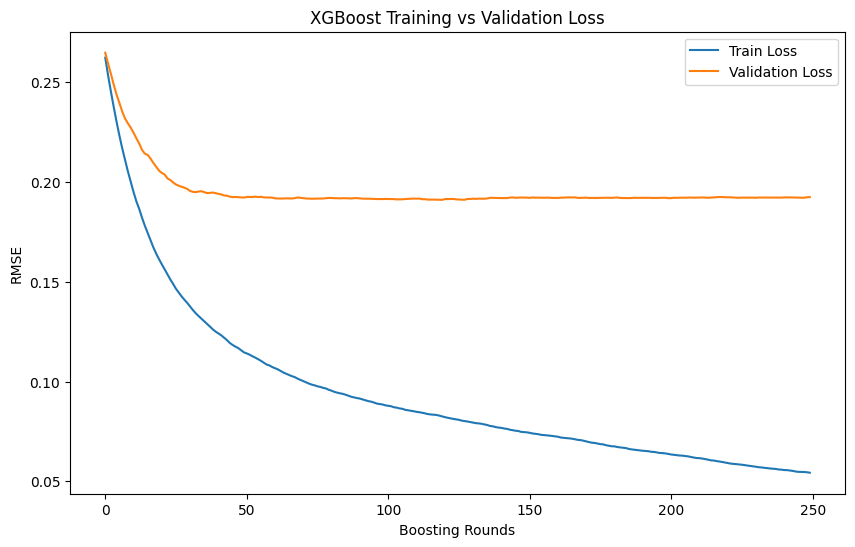

In [58]:
# Define train and validation sets for evaluation
X_train = train[features]
y_train = train["champion_share"]
X_val = test[features]
y_val = test["champion_share"]

# Train XGBoost with eval_set
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=250,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="rmse"  # Pass eval_metric here
)
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False,  # Set to True if you want progress printed
)

# Retrieve and plot training vs validation losses
results = xgb.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train Loss')
plt.plot(results['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation Loss')
plt.legend()
plt.show()


In [64]:
# Set up data_columns
data_columns = ['rk_conference', 'top_3_conference', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
                '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'opp_G', 'opp_MP', 'opp_FG',
                'opp_FGA', 'opp_FG%', 'opp_3P', 'opp_3PA', 'opp_3P%', 'opp_2P', 'opp_2PA', 'opp_2P%', 'opp_FT', 'opp_FTA', 'opp_FT%',
                'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_STL', 'opp_BLK', 'opp_TOV', 'opp_PF', 'opp_PTS', 'pso', 'over500_rec',
                'over600_rec', 'sum_wins_20pts_or_more', 'rec_5pt_or_less', 'sum_games_5pts_or_less', 'home_rec', 'road_rec', '3pt_or_less_rec',
                '10pt_or_more_rec', 'pre_all_star_rec', 'post_all_star_rec', 'e_conf_rec', 'w_conf_rec', 'sum_mvp_shares', 'sum_dpoy_shares', 
                'sum_roy_shares', 'sum_smoy_shares', 'sum_mip_shares', 'sum_cpoy_shares', 'sum_all_nba', 'sum_all_defense', 'sum_all_rookie',
                'sum_mvps_won', 'sum_dpoys_won', 'sum_roys_won', 'sum_mips_won', 'sum_cpoys_won', 'sum_all_nba_1st', 'sum_all_def_1st', 'sum_playoff_games',
                'sum_mvp_shares_L3S', 'sum_mvp_shares_L5S', 'sum_champion_shares', 'sum_champions', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs',
                'sum_player_L8S_cs', 'sum_all_nba_1st_L5S', 'team_rating_custom', 'max_player_rating_custom','sum_coach_playoff_games', 'sum_coy_shares',
                'conference_5pt_or_less_rec', 'conference_OR', 'conference_SRS', 'conference_age', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'NRtg', 
                'Pace', 'FTr', '3PAr', 'TS%', 'offensive_eFG%', 'offensive_TOV%', 'offensive_ORB%', 'offensive_FT/FGA', 'defensive_eFG%', 'defensive_TOV%',
                'defensive_DRB%', 'defensive_FT/FGA','overall_record', 'rk_season','sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs',
                 'rank_offensive_eFG%', 'rank_2P%', 'rank_sum_all_nba_1st_L5S', 'rank_SRS', 'top_5_offensive_eFG%', 'top_3_2P%', 'top_5_sum_all_nba_1st_L5S', 'top_6_SRS'
               ]

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']

# Scale features
scaler = MinMaxScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Define extended parameter grids
param_grid_sgd = {
    "alpha": [0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
    "l1_ratio": [0.05, 0.1, 0.15, 0.2],
    "learning_rate": ["adaptive"],
    "eta0": [0.005, 0.01, 0.02, 0.03],
}

param_grid_xgb = {
    "n_estimators": [150, 180, 200, 220, 250],
    "max_depth": [1, 2, 3, 4],
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "subsample": [0.8, 0.85, 0.9, 0.95],
    "colsample_bytree": [0.8, 0.85, 0.9, 0.95],
}

# Train SGDRegressor with extended GridSearchCV
sgd = SGDRegressor(penalty="elasticnet", loss="squared_error", random_state=42, max_iter=5000)
grid_search_sgd = GridSearchCV(sgd, param_grid=param_grid_sgd, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_sgd.fit(train[features], train["champion_share"])
best_model_sgd = grid_search_sgd.best_estimator_
print("Extended SGD Best Parameters:")
print(grid_search_sgd.best_params_)

# Train XGBoost with extended GridSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
grid_search_xgb = GridSearchCV(
    xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
grid_search_xgb.fit(train[features], train["champion_share"])
best_model_xgb = grid_search_xgb.best_estimator_
print("Extended XGBoost Best Parameters:")
print(grid_search_xgb.best_params_)

# Predictions for sub-models
sgd_preds = best_model_sgd.predict(test[features])
xgb_preds = best_model_xgb.predict(test[features])

# Evaluate and display predictions for each sub-model
for model_name, preds in [("SGD", sgd_preds), ("XGBoost", xgb_preds)]:
    test[f"{model_name}_predicted_cs"] = preds
    top_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, f"{model_name}_predicted_cs"))
    accuracy = (
        top_predictions.groupby("Season").first()["Team"].values
        == test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])["Team"].values
    ).mean()
    print(f"{model_name} Champion Prediction Accuracy: {accuracy:.4f}")
    print(f"\n{model_name} Top 3 Predicted Teams per Season:")
    for season, group in top_predictions.groupby("Season"):
        print(f"Season {season}:")
        print(group[["Team", f"{model_name}_predicted_cs"]].to_string(index=False))
        print("-" * 40)

# Tune ensemble weights using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_weights = None
best_cv_mse = float('inf')

for sgd_weight in np.linspace(0, 1, 21):  # Fine-grained search in 0.05 increments
    xgb_weight = 1 - sgd_weight
    cv_mse = 0
    
    for train_index, val_index in kf.split(train):
        X_train, X_val = train.iloc[train_index][features], train.iloc[val_index][features]
        y_train, y_val = train.iloc[train_index]["champion_share"], train.iloc[val_index]["champion_share"]

        sgd_preds_val = best_model_sgd.predict(X_val)
        xgb_preds_val = best_model_xgb.predict(X_val)
        ensemble_preds = sgd_weight * sgd_preds_val + xgb_weight * xgb_preds_val
        cv_mse += mean_squared_error(y_val, ensemble_preds)
    
    cv_mse /= kf.get_n_splits()
    
    if cv_mse < best_cv_mse:
        best_cv_mse = cv_mse
        best_weights = (sgd_weight, xgb_weight)

print(f"Best Ensemble Weights: SGD={best_weights[0]:.2f}, XGB={best_weights[1]:.2f} with CV MSE={best_cv_mse:.4f}")

# Combine predictions on test set using best weights
# ensemble_preds = best_weights[0] * sgd_preds + best_weights[1] * xgb_preds
ensemble_preds = 0.15 * sgd_preds + 0.85 * xgb_preds
test["predicted_cs"] = ensemble_preds

# Regression MSE
mse = mean_squared_error(test["champion_share"], ensemble_preds)
print(f"Ensemble Test Set Mean Squared Error (MSE): {mse:.4f}")

# Champion prediction for ensemble
champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])

# Accuracy for predicting champions
ensemble_accuracy = (
    champion_predictions.groupby("Season").first()["Team"].values
    == actual_champions["Team"].values
).mean()
print(f"Ensemble Champion Prediction Accuracy: {ensemble_accuracy:.4f}")

# Print top 3 predicted teams for ensemble
print("\nEnsemble Top 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)


Extended SGD Best Parameters:
{'alpha': 0.002, 'eta0': 0.005, 'l1_ratio': 0.05, 'learning_rate': 'adaptive'}
Extended XGBoost Best Parameters:
{'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 1, 'n_estimators': 220, 'subsample': 0.85}
SGD Champion Prediction Accuracy: 0.8000

SGD Top 3 Predicted Teams per Season:
Season 2020:
                Team  SGD_predicted_cs
  Los Angeles Lakers          0.678096
     Milwaukee Bucks          0.658685
Los Angeles Clippers          0.557070
----------------------------------------
Season 2021:
                Team  SGD_predicted_cs
     Milwaukee Bucks          0.640346
           Utah Jazz          0.606307
Los Angeles Clippers          0.593780
----------------------------------------
Season 2022:
                 Team  SGD_predicted_cs
Golden State Warriors          0.638533
         Phoenix Suns          0.619365
           Miami Heat          0.548909
----------------------------------------
Season 2023:
           Team  SGD_pred

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2586342984.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, f"{model_name}_predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2586342984.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  == test.groupby("Season", group_

Best Ensemble Weights: SGD=0.35, XGB=0.65 with CV MSE=0.0243
Ensemble Test Set Mean Squared Error (MSE): 0.0360
Ensemble Champion Prediction Accuracy: 1.0000

Ensemble Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.673233
Los Angeles Clippers      0.628554
     Milwaukee Bucks      0.557251
----------------------------------------
Season 2021:
                Team  predicted_cs
     Milwaukee Bucks      0.556002
Los Angeles Clippers      0.546335
  Philadelphia 76ers      0.522860
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.553048
         Phoenix Suns      0.550172
           Miami Heat      0.503244
----------------------------------------
Season 2023:
           Team  predicted_cs
 Denver Nuggets      0.556698
 Boston Celtics      0.554556
Milwaukee Bucks      0.547540
----------------------------------------
Season 2024:
                 Team  pr

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2586342984.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/2586342984.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season

SGD Validation MSE: 0.0338
XGBoost Validation MSE: 0.0369


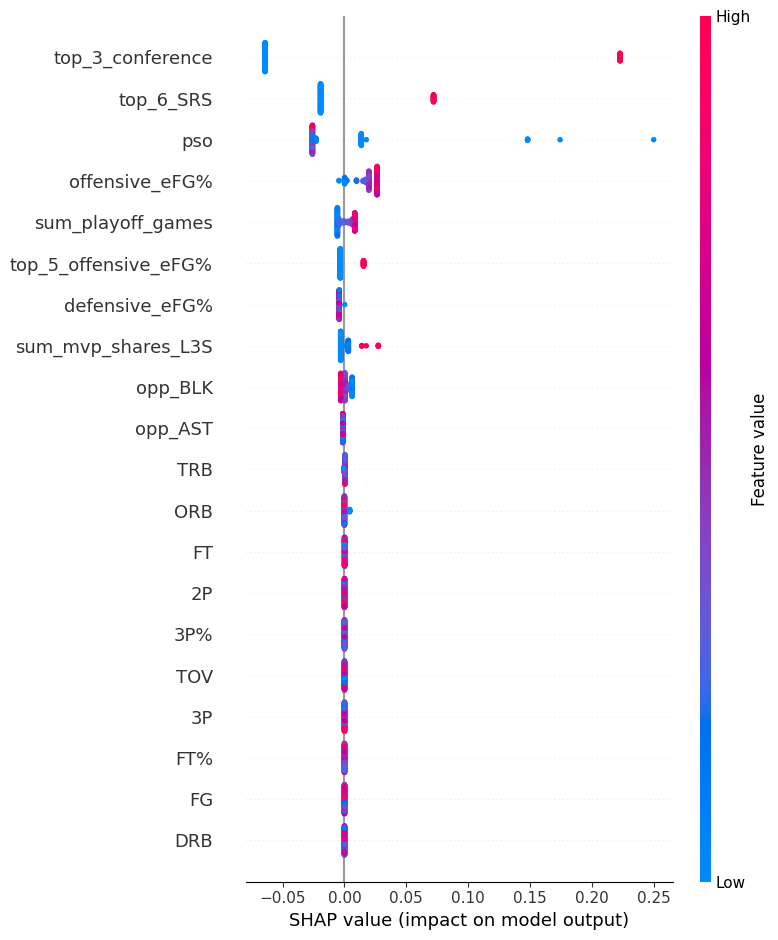

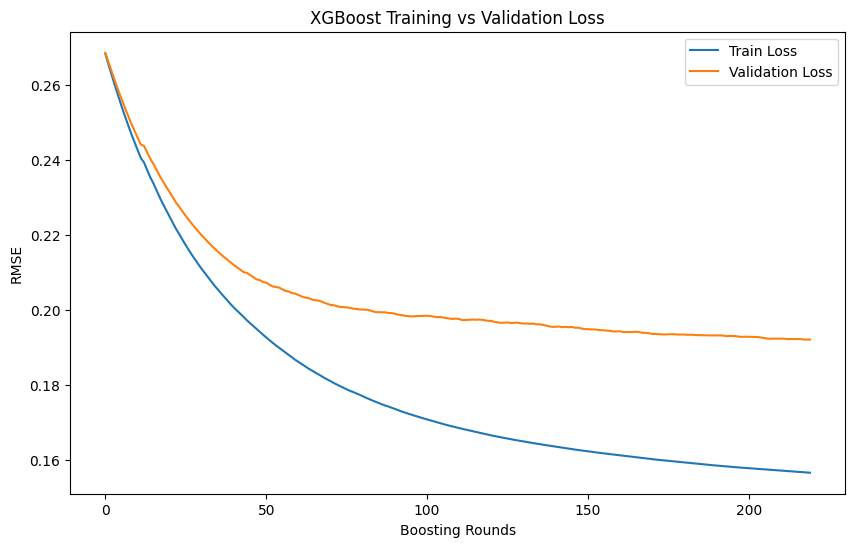

Ensemble Validation MSE: 0.0360
Ensemble Champion Prediction Accuracy: 1.0000

Ensemble Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.673233
Los Angeles Clippers      0.628554
     Milwaukee Bucks      0.557251
----------------------------------------
Season 2021:
                Team  predicted_cs
     Milwaukee Bucks      0.556002
Los Angeles Clippers      0.546335
  Philadelphia 76ers      0.522860
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.553048
         Phoenix Suns      0.550172
           Miami Heat      0.503244
----------------------------------------
Season 2023:
           Team  predicted_cs
 Denver Nuggets      0.556698
 Boston Celtics      0.554556
Milwaukee Bucks      0.547540
----------------------------------------
Season 2024:
                 Team  predicted_cs
       Boston Celtics      0.669476
       Denver Nuggets      0.6556

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/3170441931.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/3170441931.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season",

In [77]:
import shap
import matplotlib.pyplot as plt

# Best parameters for SGD and XGBoost
sgd_best_params = {'alpha': 0.002, 'eta0': 0.005, 'l1_ratio': 0.05, 'learning_rate': 'adaptive'}
xgb_best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.02,
    'max_depth': 1,
    'n_estimators': 220,
    'subsample': 0.85
}

# Train and Validation sets
X_train = train[features]
y_train = train["champion_share"]
X_val = test[features]
y_val = test["champion_share"]

# Fit SGD with best parameters
sgd = SGDRegressor(
    penalty="elasticnet",
    loss="squared_error",
    random_state=42,
    max_iter=5000,
    **sgd_best_params
)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_val)
sgd_mse = mean_squared_error(y_val, sgd_preds)
print(f"SGD Validation MSE: {sgd_mse:.4f}")

# Fit XGBoost with best parameters
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, eval_metric="rmse", **xgb_best_params)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
xgb_preds = xgb.predict(X_val)
xgb_mse = mean_squared_error(y_val, xgb_preds)
print(f"XGBoost Validation MSE: {xgb_mse:.4f}")

# SHAP feature importance
explainer = shap.Explainer(xgb)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, show=True)

# XGBoost Train/Validation Loss Plot
results = xgb.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train Loss')
plt.plot(results['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation Loss')
plt.legend()
plt.show()

# Combine predictions with best weights
ensemble_preds = 0.15 * sgd_preds + 0.85 * xgb_preds
test["predicted_cs"] = ensemble_preds

# Ensemble MSE
ensemble_mse = mean_squared_error(y_val, ensemble_preds)
print(f"Ensemble Validation MSE: {ensemble_mse:.4f}")

# Champion prediction for ensemble
champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])

# Accuracy for predicting champions
ensemble_accuracy = (
    champion_predictions.groupby("Season").first()["Team"].values
    == actual_champions["Team"].values
).mean()
print(f"Ensemble Champion Prediction Accuracy: {ensemble_accuracy:.4f}")

# Print top 3 predicted teams for ensemble
print("\nEnsemble Top 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)


In [79]:
# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']


print(len(features))

35


In [80]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load and preprocess data
df = pd.read_csv("NBA Champion RawData.csv")
df.rename(columns={'season': 'Season'}, inplace=True)

# Drop seasons before 1986
df = df[df["Season"] >= 1986]

# Train/test split
train = df[df["Season"] < 2020].copy()
test = df[df["Season"] >= 2020].copy()

# Define your selected features
features = ['top_3_conference', 'FG', '3P', '3P%', '2P', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 
            'opp_3P%', 'opp_FT%', 'opp_ORB', 'opp_DRB', 'opp_TRB', 'opp_AST', 'opp_BLK', 'Age', 'pso', 
            'sum_mvp_shares_L3S', 'top_6_SRS', 'top_5_offensive_eFG%', 'sum_franchise_L3S_cs', 'sum_playoff_games', 
            'sum_games_5pts_or_less', 'sum_roy_shares', '3pt_or_less_rec', 'offensive_eFG%', 'conference_OR', 
            'defensive_eFG%', 'sum_dpoys_won']

# Scale features
scaler = MinMaxScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# Print the number of features and examples
print("Training set: Number of examples =", train.shape[0], ", Number of features =", len(features))
print("Test set: Number of examples =", test.shape[0], ", Number of features =", len(features))


Training set: Number of examples = 967 , Number of features = 35
Test set: Number of examples = 150 , Number of features = 35


SGD Validation MSE: 0.0338
XGBoost Validation MSE: 0.0369


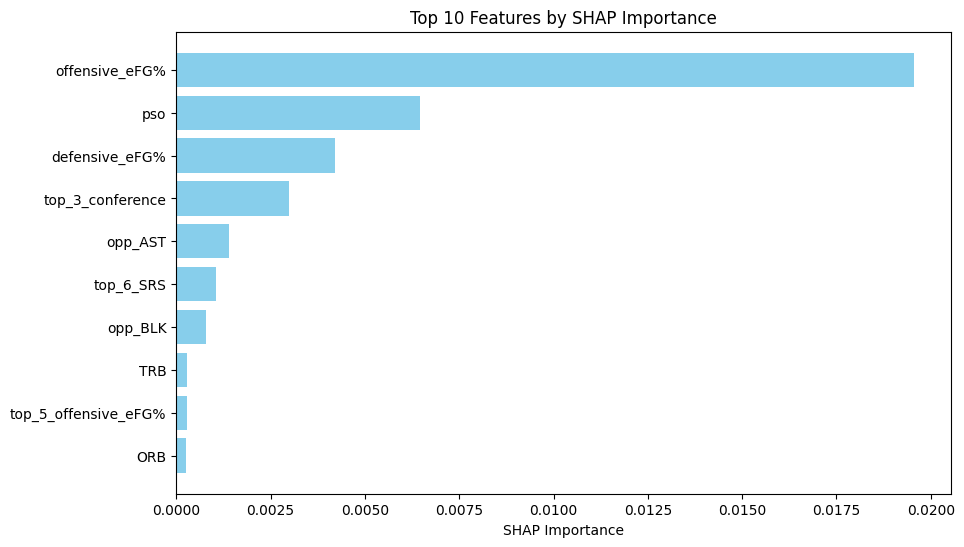

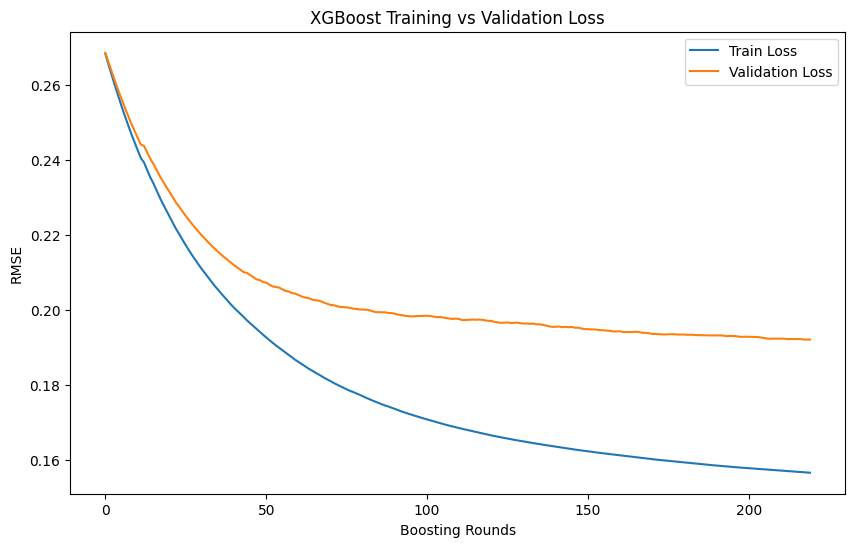

Ensemble Validation MSE: 0.0360
Ensemble Champion Prediction Accuracy: 1.0000

Ensemble Top 3 Predicted Teams per Season:
Season 2020:
                Team  predicted_cs
  Los Angeles Lakers      0.673233
Los Angeles Clippers      0.628554
     Milwaukee Bucks      0.557251
----------------------------------------
Season 2021:
                Team  predicted_cs
     Milwaukee Bucks      0.556002
Los Angeles Clippers      0.546335
  Philadelphia 76ers      0.522860
----------------------------------------
Season 2022:
                 Team  predicted_cs
Golden State Warriors      0.553048
         Phoenix Suns      0.550172
           Miami Heat      0.503244
----------------------------------------
Season 2023:
           Team  predicted_cs
 Denver Nuggets      0.556698
 Boston Celtics      0.554556
Milwaukee Bucks      0.547540
----------------------------------------
Season 2024:
                 Team  predicted_cs
       Boston Celtics      0.669476
       Denver Nuggets      0.6556

/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/590382049.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
/var/folders/n8/kn3_t_b17xqb63cgxp4k7_8w0000gn/T/ipykernel_5455/590382049.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_champions = test.groupby("Season", g

In [81]:
# Revised code block for SHAP summary bar chart with top 10 features
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Best parameters for SGD and XGBoost
sgd_best_params = {'alpha': 0.002, 'eta0': 0.005, 'l1_ratio': 0.05, 'learning_rate': 'adaptive'}
xgb_best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.02,
    'max_depth': 1,
    'n_estimators': 220,
    'subsample': 0.85
}

# Train and Validation sets
X_train = train[features]
y_train = train["champion_share"]
X_val = test[features]
y_val = test["champion_share"]

# Fit SGD with best parameters
sgd = SGDRegressor(
    penalty="elasticnet",
    loss="squared_error",
    random_state=42,
    max_iter=5000,
    **sgd_best_params
)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_val)
sgd_mse = mean_squared_error(y_val, sgd_preds)
print(f"SGD Validation MSE: {sgd_mse:.4f}")

# Fit XGBoost with best parameters
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, eval_metric="rmse", **xgb_best_params)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
xgb_preds = xgb.predict(X_val)
xgb_mse = mean_squared_error(y_val, xgb_preds)
print(f"XGBoost Validation MSE: {xgb_mse:.4f}")

# SHAP feature importance (Bar chart with top 10 features)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_val)
shap_values_df = shap_values.values.mean(axis=0)
shap_feature_importance = pd.DataFrame({
    "Feature": X_val.columns,
    "Importance": np.abs(shap_values_df)
}).sort_values(by="Importance", ascending=False)

# Top 10 features
top_10_features = shap_feature_importance.head(10)

# Plot SHAP summary bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], color="skyblue")
plt.xlabel("SHAP Importance")
plt.title("Top 10 Features by SHAP Importance")
plt.gca().invert_yaxis()
plt.show()

# XGBoost Train/Validation Loss Plot
results = xgb.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='Train Loss')
plt.plot(results['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Training vs Validation Loss')
plt.legend()
plt.show()

# Combine predictions with best weights
ensemble_preds = 0.15 * sgd_preds + 0.85 * xgb_preds
test["predicted_cs"] = ensemble_preds

# Ensemble MSE
ensemble_mse = mean_squared_error(y_val, ensemble_preds)
print(f"Ensemble Validation MSE: {ensemble_mse:.4f}")

# Champion prediction for ensemble
champion_predictions = test.groupby("Season", group_keys=False).apply(lambda df: df.nlargest(3, "predicted_cs"))
actual_champions = test.groupby("Season", group_keys=False).apply(lambda df: df.loc[df["champion_share"].idxmax()])

# Accuracy for predicting champions
ensemble_accuracy = (
    champion_predictions.groupby("Season").first()["Team"].values
    == actual_champions["Team"].values
).mean()
print(f"Ensemble Champion Prediction Accuracy: {ensemble_accuracy:.4f}")

# Print top 3 predicted teams for ensemble
print("\nEnsemble Top 3 Predicted Teams per Season:")
for season, group in champion_predictions.groupby("Season"):
    print(f"Season {season}:")
    print(group[["Team", "predicted_cs"]].to_string(index=False))
    print("-" * 40)

